In [24]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ad_config_search.process_pylot_runs import (
    get_accuracies,
    get_coco_accuracies,
    get_latencies,
)
from tqdm import tqdm

In [25]:
def create_df_from_dir(DATA_PATH):
    unique_runs = list(set([path.stem.split(".")[0] for path in Path(DATA_PATH).iterdir()]))
    df = pd.DataFrame(columns=["model_name", "run_name", "latencies", "accuracies"])
    
    for run in tqdm(unique_runs):
        splitted_run = run.split("-")
        if splitted_run[0] == "faster":
            model_name = "frcnn"
            run_name = "-".join(splitted_run[2:])
        elif splitted_run[0] == "efficientdet":
            model_name = "edet-{}".format(splitted_run[1])
            run_name = "-".join(splitted_run[2:])
            if model_name == "edet-d6":
                continue
        elif splitted_run[0] == "ssdlite":
            model_name = "ssd-v2"
            run_name = "-".join(splitted_run[3:])
        for k,v in get_coco_accuracies(DATA_PATH, run).items():
            df = df.append({"model_name": model_name,
                            "run_name": run_name,
                            "latencies": get_latencies(DATA_PATH, run),
                            "accuracies": list(filter(lambda x: x != -1, v)),
                            "coco_metric": k}, ignore_index=True)

    df["mean_lat"] = df["latencies"].apply(lambda x: np.mean(x)/1000.)
    df["mean_mAP_acc"] = df["accuracies"].apply(lambda x: np.mean(x))
    df["town"] = df["run_name"].apply(lambda s: s.split("_")[1])
    df["train"] = df["run_name"].apply(lambda s: "train" if "Training" in s else "test")
    df["town-train"] = df["town"]+"-"+df["train"]
    df["resolution"] = df["run_name"].apply(lambda s: "({}, {})".format(*s.split("-")[-2:]))
    
    df["mAP_data_length"] = df["accuracies"].apply(lambda a: len(a))
    df["lat_data_length"] = df["latencies"].apply(lambda a: len(a))
    
    return df

In [28]:
df_sync = create_df_from_dir("../scripts/sweep_files/")

100%|██████████| 72/72 [00:08<00:00,  8.47it/s]


In [29]:
df = df_sync

In [30]:
df = df.sort_values(by=["resolution", "model_name", "coco_metric"])

In [31]:
df.columns

Index(['model_name', 'run_name', 'latencies', 'accuracies', 'coco_metric',
       'mean_lat', 'mean_mAP_acc', 'town', 'train', 'town-train', 'resolution',
       'mAP_data_length', 'lat_data_length'],
      dtype='object')

In [32]:
df["index"] = np.arange(len(df))

In [33]:
len(df)

864

### (1080, 1920) resolution

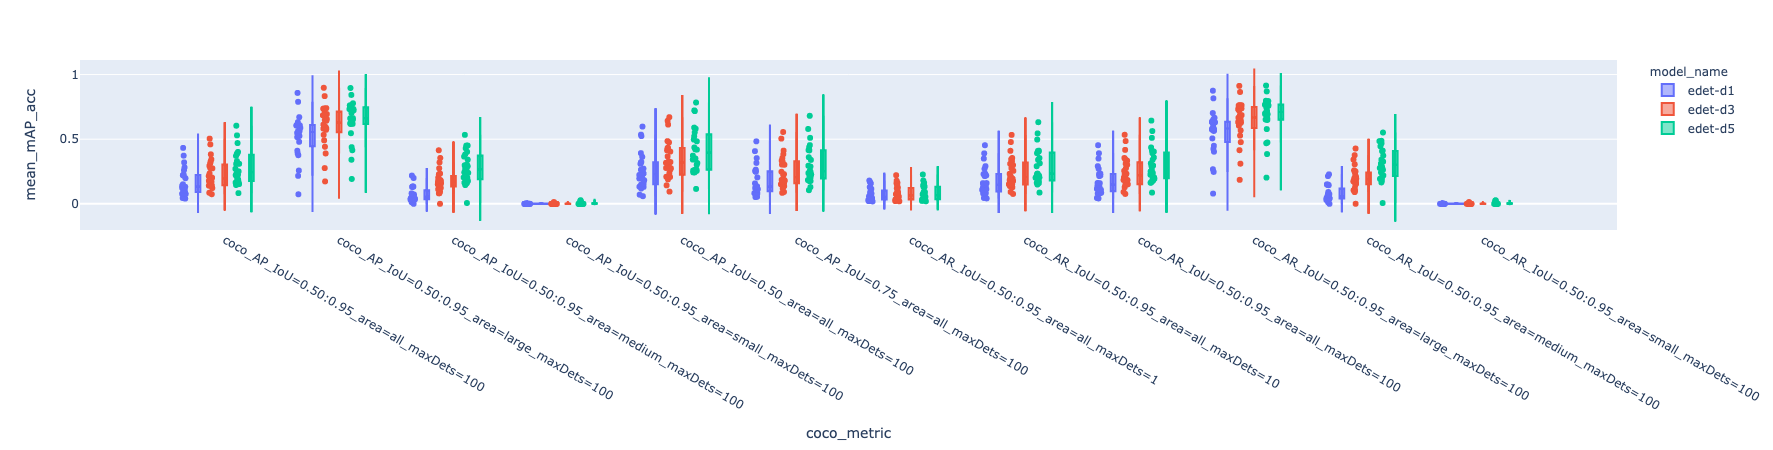

In [34]:
import plotly.express as px

fig = px.violin(df.loc[(df["resolution"] == '(1080, 1920)')], y="mean_mAP_acc", x="coco_metric", color="model_name", box=True, points="all", hover_data=["model_name", "run_name", "mean_lat", "mean_mAP_acc"])
fig.show()

In [35]:
df["coco_AP-AR"] = df["coco_metric"].apply(lambda x: x.split("_")[1])
print(df["coco_AP-AR"].unique())

['AP' 'AR']


In [36]:
df["coco_bbox_area"] = df["coco_metric"].apply(lambda x: x.split("area=")[1].split("_")[0])
print(df["coco_bbox_area"].unique())
df["model_name_coco_bbox_area"] = [x+"_"+y for x, y in zip(df["model_name"], df["coco_bbox_area"])]
df["model_name_coco_bbox_area"].unique()

['all' 'large' 'medium' 'small']


array(['edet-d1_all', 'edet-d1_large', 'edet-d1_medium', 'edet-d1_small',
       'edet-d3_all', 'edet-d3_large', 'edet-d3_medium', 'edet-d3_small',
       'edet-d5_all', 'edet-d5_large', 'edet-d5_medium', 'edet-d5_small'],
      dtype=object)

In [37]:
df["coco_metric"].unique()

array(['coco_AP_IoU=0.50:0.95_area=all_maxDets=100',
       'coco_AP_IoU=0.50:0.95_area=large_maxDets=100',
       'coco_AP_IoU=0.50:0.95_area=medium_maxDets=100',
       'coco_AP_IoU=0.50:0.95_area=small_maxDets=100',
       'coco_AP_IoU=0.50_area=all_maxDets=100',
       'coco_AP_IoU=0.75_area=all_maxDets=100',
       'coco_AR_IoU=0.50:0.95_area=all_maxDets=1',
       'coco_AR_IoU=0.50:0.95_area=all_maxDets=10',
       'coco_AR_IoU=0.50:0.95_area=all_maxDets=100',
       'coco_AR_IoU=0.50:0.95_area=large_maxDets=100',
       'coco_AR_IoU=0.50:0.95_area=medium_maxDets=100',
       'coco_AR_IoU=0.50:0.95_area=small_maxDets=100'], dtype=object)

In [38]:
df["coco_max_det"] = df["coco_metric"].apply(lambda x: x.split("maxDets=")[1].split("_")[0])
print(df["coco_max_det"].unique())
df["model_name_coco_max_det"] = [x+"_"+y for x, y in zip(df["model_name"], df["coco_max_det"])]
df["model_name_coco_max_det"].unique()

['100' '1' '10']


array(['edet-d1_100', 'edet-d1_1', 'edet-d1_10', 'edet-d3_100',
       'edet-d3_1', 'edet-d3_10', 'edet-d5_100', 'edet-d5_1',
       'edet-d5_10'], dtype=object)

In [39]:
df["coco_iou"] = df["coco_metric"].apply(lambda x: x.split("IoU=")[1].split("_")[0])
print(df["coco_iou"].unique())
df["model_name_coco_iou"] = [x+"_"+y for x, y in zip(df["model_name"], df["coco_iou"])]
df["model_name_coco_iou"].unique()

['0.50:0.95' '0.50' '0.75']


array(['edet-d1_0.50:0.95', 'edet-d1_0.50', 'edet-d1_0.75',
       'edet-d3_0.50:0.95', 'edet-d3_0.50', 'edet-d3_0.75',
       'edet-d5_0.50:0.95', 'edet-d5_0.50', 'edet-d5_0.75'], dtype=object)

In [40]:
df["mean_mAP_acc"]

24     0.432569
36     0.226492
108    0.151026
144    0.079803
168    0.123078
         ...   
657    0.001413
705    0.001001
729    0.026733
813    0.000000
861    0.000000
Name: mean_mAP_acc, Length: 864, dtype: float64

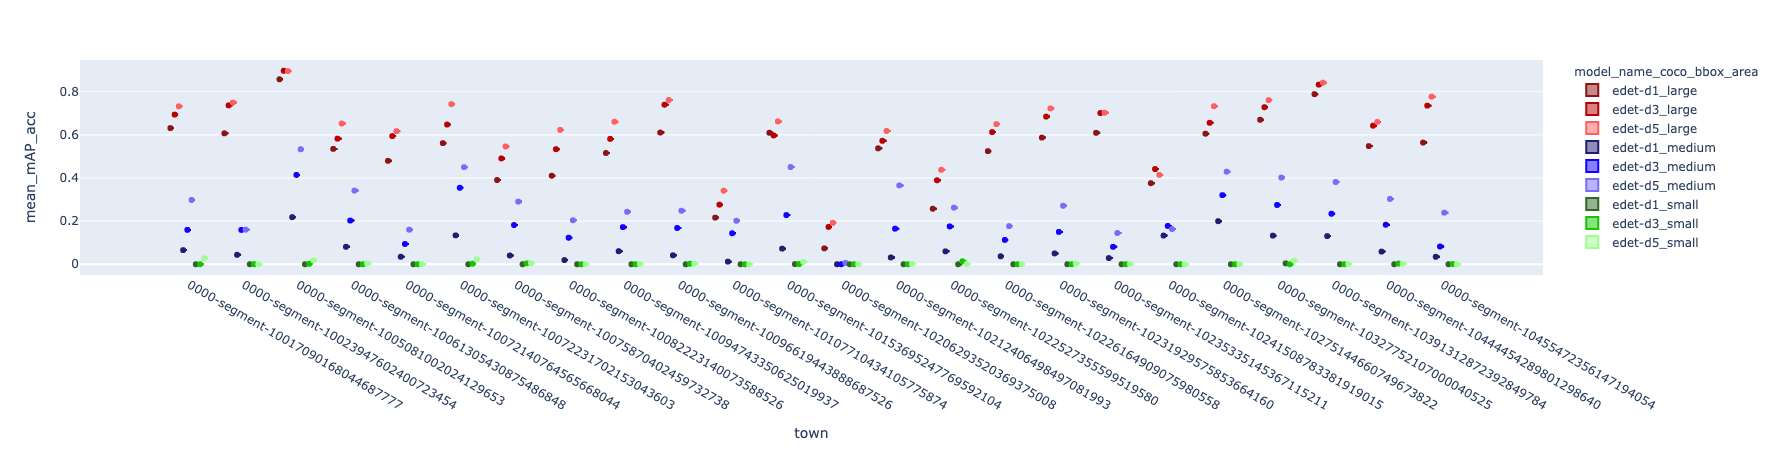

In [41]:
import plotly.express as px

df = df.sort_values(by=["town", "coco_metric"])
fig = px.violin(df.loc[((df["model_name"] == "edet-d1") | (df["model_name"] == "edet-d3") | (df["model_name"] == "edet-d5")) & (df["coco_AP-AR"] == "AP") & (df["coco_bbox_area"] != "all") & (df["resolution"] == "(1080, 1920)") & (df["coco_max_det"] == "100") & (df["coco_iou"] == "0.50:0.95")],
                y="mean_mAP_acc", x="town", color="model_name_coco_bbox_area", box=True, points="all", hover_data=["model_name", "resolution", "mean_lat", "mean_mAP_acc", "coco_metric", "run_name", "index"],
                category_orders={"model_name_coco_bbox_area": 
                                 ['edet-d1_large', 'edet-d3_large', 'edet-d5_large', 'edet-d1_medium', 'edet-d3_medium', 'edet-d5_medium', 'edet-d1_small', 'edet-d3_small', 'edet-d5_small']
                                },
                color_discrete_sequence=["#8c1414", "#b80202", "#fc6060", "#231d70", "#1200ff", "#776df7", "#2d6625", "#18c400", "#9dff8f"]
               )
fig.show()

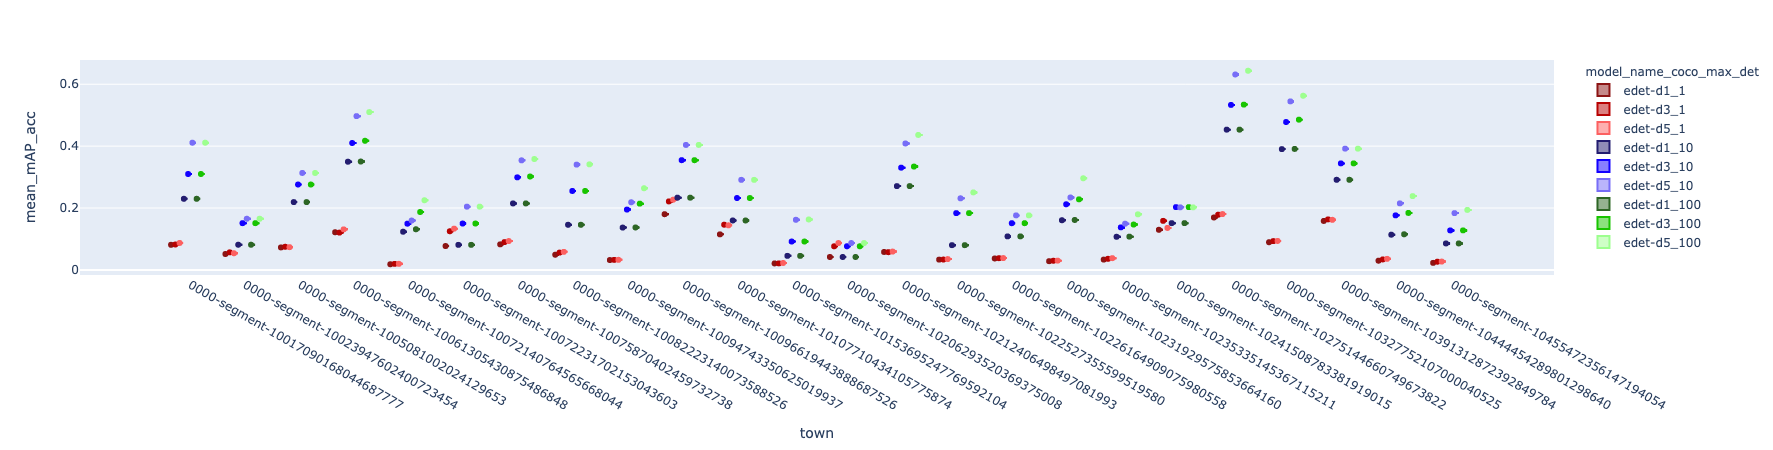

In [42]:
import plotly.express as px

df = df.sort_values(by=["town", "coco_metric"])
fig = px.violin(df.loc[((df["model_name"] == "edet-d1") | (df["model_name"] == "edet-d3") | (df["model_name"] == "edet-d5")) & (df["coco_AP-AR"] == "AR") & (df["resolution"] == "(1080, 1920)") & (df["coco_bbox_area"] == "all") & (df["coco_iou"] == "0.50:0.95")], 
                y="mean_mAP_acc", x="town", color="model_name_coco_max_det", box=True, points="all", hover_data=["model_name", "resolution", "mean_lat", "mean_mAP_acc", "coco_AP-AR"],
                category_orders={"model_name_coco_max_det": 
                                 ['edet-d1_1', 'edet-d3_1', 'edet-d5_1', 'edet-d1_10', 'edet-d3_10', 'edet-d5_10', 'edet-d1_100', 'edet-d3_100', 'edet-d5_100']
                                },
                color_discrete_sequence=["#8c1414", "#b80202", "#fc6060", "#231d70", "#1200ff", "#776df7", "#2d6625", "#18c400", "#9dff8f"]
               )
fig.show()

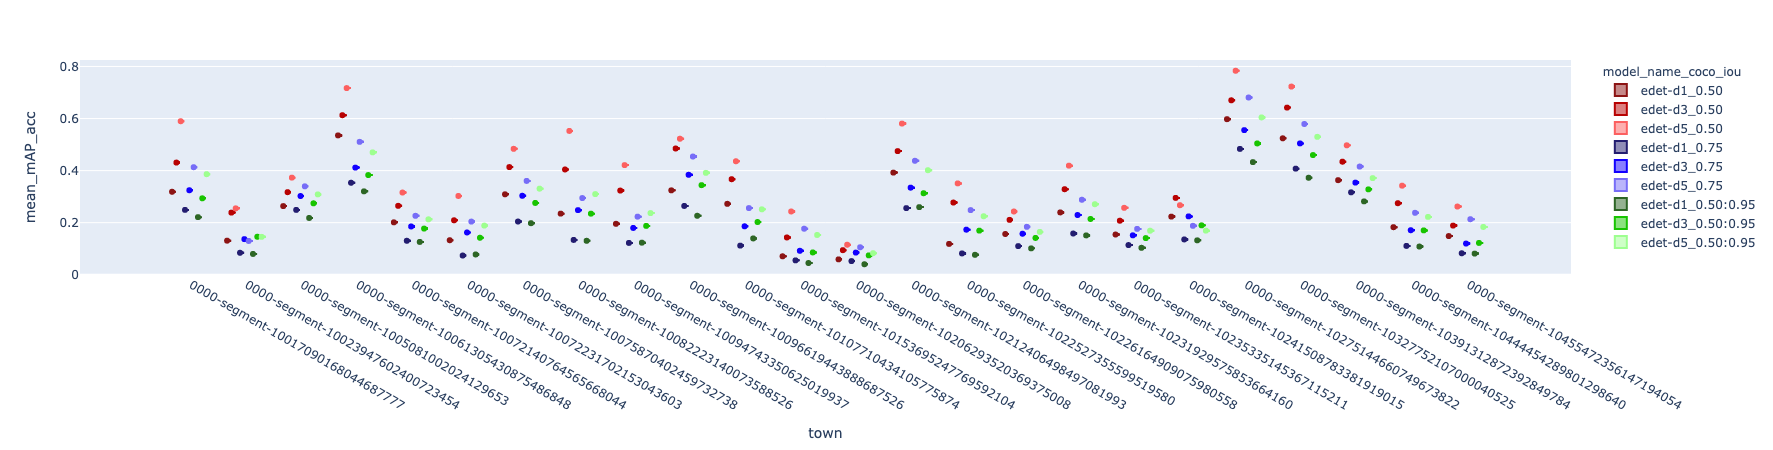

In [43]:
import plotly.express as px

df = df.sort_values(by=["town", "coco_metric"])
fig = px.violin(df.loc[((df["model_name"] == "edet-d1") | (df["model_name"] == "edet-d3") | (df["model_name"] == "edet-d5")) & (df["coco_AP-AR"] == "AP") & (df["resolution"] == "(1080, 1920)") & (df["coco_bbox_area"] == "all") & (df["coco_max_det"] == "100")], 
                y="mean_mAP_acc", x="town", color="model_name_coco_iou", box=True, points="all", hover_data=["model_name", "resolution", "mean_lat", "mean_mAP_acc", "coco_metric", "index", "coco_AP-AR"],
                category_orders={"model_name_coco_iou": 
                                 ['edet-d1_0.50', 'edet-d3_0.50', 'edet-d5_0.50', 'edet-d1_0.75', 'edet-d3_0.75', 'edet-d5_0.75', 'edet-d1_0.50:0.95', 'edet-d3_0.50:0.95', 'edet-d5_0.50:0.95']
                                },
                color_discrete_sequence=["#8c1414", "#b80202", "#fc6060", "#231d70", "#1200ff", "#776df7", "#2d6625", "#18c400", "#9dff8f"]
               )
fig.show()

In [61]:
[p.name.split(".")[1] for p in Path(".").iterdir()]

IndexError: list index out of range

In [59]:
Path("timeley-mAP-eval.ipynb").name.split(".")[1]

'ipynb'